**Лабороторная работа №3**

**Задание**

Выполнить реализацию SGD в Numba и сравнить с реализацией в ЛР №1

Импортируем библиотеки

In [1]:
from typing import Tuple, Mapping
from matplotlib.ticker import MaxNLocator

import numpy as np
import random
import IPython
from matplotlib import pyplot as plt
import sklearn as skl
from sklearn import datasets
from IPython import display

Функция Химмельблау и градиент

In [6]:
def Himmelblau(x: np.float32, y: np.float32) -> np.float64:
    return np.square(np.square(x)+y-11)+np.square(x+np.square(y)-7);

def Himmelblau_Grad(x: np.float32, y: np.float32) -> np.array:
    return np.array([(4*x*(np.square(x)+y-11)+2*(x+np.square(y)-7)), (2*(np.square(x)+y-11)+4*y*(x+np.square(y)-7))]);

print('f(3, 2) = 0')
print('f(-2.805118, 3.131312) = 0')
print('f(-3.779310, -3.283186) = 0')
print('f(3.584428, -1.848126) = 0')
print('Himmelblau Result 1: ', Himmelblau(3, 2))
print('Himmelblau Result 2: ', Himmelblau(-2.805118, 3.131312))
print('Himmelblau Result 3: ', Himmelblau(-3.779310, -3.283186))
print('Himmelblau Result 4: ', Himmelblau(3.584428, -1.848126))
print('Himmelblau Gradient Result 1: ', Himmelblau_Grad(3, 2))
print('Himmelblau Gradient Result 2: ', Himmelblau_Grad(-2.805118, 3.131312))
print('Himmelblau Gradient Result 3: ', Himmelblau_Grad(-3.779310, -3.283186))
print('Himmelblau Gradient Result 4: ', Himmelblau_Grad(3.584428, -1.848126))

f(3, 2) = 0
f(-2.805118, 3.131312) = 0
f(-3.779310, -3.283186) = 0
f(3.584428, -1.848126) = 0
Himmelblau Result 1:  0
Himmelblau Result 2:  1.0989296656869089e-11
Himmelblau Result 3:  3.797861082863832e-12
Himmelblau Result 4:  8.894376497582423e-12
Himmelblau Gradient Result 1:  [0 0]
Himmelblau Gradient Result 2:  [ 4.97133560e-06 -4.15751018e-05]
Himmelblau Gradient Result 3:  [ 2.97052500e-05 -7.92677776e-06]
Himmelblau Gradient Result 4:  [-3.20016529e-05  1.30893338e-05]


Выведем изображение

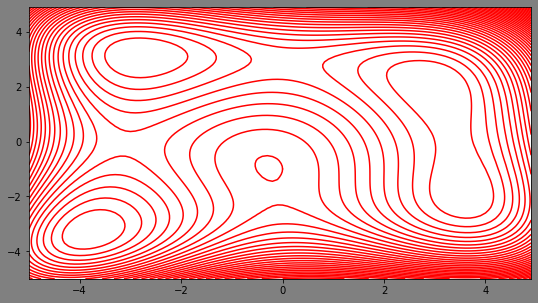

In [7]:
grid_points = 100
a = b = np.arange(-5.0, 5.0, 0.1)
X, Y = np.meshgrid(a, b)
c = np.array(Himmelblau(np.ravel(X).reshape(a.size**2,1), np.ravel(Y).reshape(a.size**2,1)))
Z = c.reshape(X.shape)

levelsf = MaxNLocator(nbins=100).tick_values(Z.min(), Z.max())
levels = MaxNLocator(nbins=20).tick_values(Z.min(), Z.max())

fig, ax = plt.subplots(figsize=(9,5), facecolor = 'grey')
cs = ax.contour(X, Y, Z, 50, colors = 'red')
    
plt.show()

Градиентный спуск

In [8]:
#GDF
def my_GD(f: Mapping, df: Mapping, x0: np.ndarray, y0: np.ndarray, lr: float = 0.01,
          T: int = 100) -> Tuple [np.ndarray, np.ndarray, np.float32]:
    '''Моя простейшая реализация градиентного спуска.
    
    Args:
        f (Mapping): Функционал для оптимизации
        df (Mapping): Градиент оптимизирующего функционала
        x0 (np.ndarray): Стартовая точка 1
        y0 (np.ndarray): Стартовая точка 2
        lr (float): Скорость обучения. Default=0,01.
        T (int): Количество итераций.
    
    Returns:
        Tuple [np.ndarray, np.ndarray, np.float32]: (x_optimal, f(x_optimal)).
        Кортеж с координатой x, координатой y и результатом функции
    
    '''
    x_old = x0;
    y_old = y0;
    for i in range(T):
        # так стабильнее
        n=df(x0, y0)
        x_new = x_old - lr*n[0]
        y_new = y_old - lr*n[1]
        
    return x_new, y_new, f(x_new, y_new)

Сгенерируем набор точек

In [9]:
z, y = skl.datasets.make_blobs(n_samples=40000, centers=2, n_features=2, random_state=0)
y = np.zeros(40000)
x = np.zeros(40000)

for i in range(len(z)):
    x[i],y[i] = z[i];
print('X: ', x)
print('Y: ', y)

X:  [ 1.58107779  2.02139889  1.74902357 ...  3.58479452 -0.5316157
  2.63024066]
Y:  [-0.21815247  0.41577863  1.10999246 ...  0.55144109  4.041054
 -0.3872784 ]


Применим алгоритм к функции Химмельблау

In [10]:
result = my_GD(Himmelblau, Himmelblau_Grad, x, y)
#gds_ind = np.argmin(result[2])
print('X: ', result[0])
print('Y: ', result[1])
print('Himmelblau Result: ', result[2])

X:  [ 2.23987973  2.64292905  2.30729932 ...  3.30256218 -0.84955542
  3.18482981]
Y:  [-0.09065633  0.62566677  1.42504858 ...  0.57202117  2.75237179
 -0.36326525]
Himmelblau Result:  [59.46912781 27.21315708 25.15964217 ... 11.58782931 56.71400556
 15.05472858]


**Numba**

Импортируем библиотеки

In [11]:
import numba
from numba import jit

Функция Химмельблау

In [12]:
@numba.njit(fastmath=True)
def Himmelblau_GPU(x: np.float32, y: np.float32) -> np.float64:
    '''
    Функция Химмельблау
    
    Args:
        x(np.ndarray): Аргумент 1
        y(np.ndarray): Аргумент 2
        
    Returns:
        np.float64: Результат функции
    '''
    return np.square(np.square(x)+y-11)+np.square(x+np.square(y)-7);

@numba.njit(fastmath=True)
def Himmelblau_Grad_GPU_1(x: np.float32, y: np.float32) -> np.float64:
    return (4*x*(np.square(x)+y-11)+2*(x+np.square(y)-7))

@numba.njit(fastmath=True)
def Himmelblau_Grad_GPU_2(x: np.float32, y: np.float32) -> np.float64:
    return (2*(np.square(x)+y-11)+4*y*(x+np.square(y)-7))

print('f(3, 2) = 0')
print('f(-2.805118, 3.131312) = 0')
print('f(-3.779310, -3.283186) = 0')
print('f(3.584428, -1.848126) = 0')
print('Himmelblau Result 1: ', Himmelblau_GPU(3, 2))
print('Himmelblau Result 2: ', Himmelblau_GPU(-2.805118, 3.131312))
print('Himmelblau Result 3: ', Himmelblau_GPU(-3.779310, -3.283186))
print('Himmelblau Result 4: ', Himmelblau_GPU(3.584428, -1.848126))

f(3, 2) = 0
f(-2.805118, 3.131312) = 0
f(-3.779310, -3.283186) = 0
f(3.584428, -1.848126) = 0
Himmelblau Result 1:  0
Himmelblau Result 2:  1.0989296654182172e-11
Himmelblau Result 3:  3.79786108288807e-12
Himmelblau Result 4:  8.894376494303697e-12


Выведем изображение

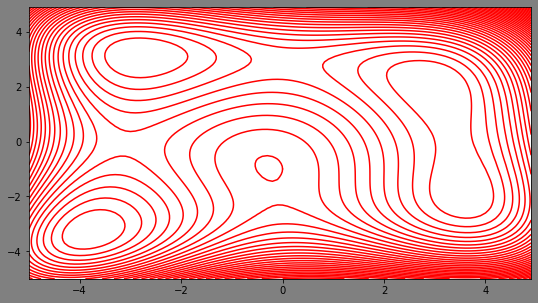

In [13]:
grid_points = 100
a = b = np.arange(-5.0, 5.0, 0.1)
X, Y = np.meshgrid(a, b)
c = np.array(Himmelblau_GPU(np.ravel(X).reshape(a.size**2,1), np.ravel(Y).reshape(a.size**2,1)))
Z = c.reshape(X.shape)

levelsf = MaxNLocator(nbins=100).tick_values(Z.min(), Z.max())
levels = MaxNLocator(nbins=20).tick_values(Z.min(), Z.max())

fig, ax = plt.subplots(figsize=(9,5), facecolor = 'grey')
cs = ax.contour(X, Y, Z, 50, colors = 'red')

plt.show()
    

Градиентный спуск

In [14]:
#GDF
@numba.njit(fastmath=True, debug=True)
def my_GD_GPU(f: Mapping, df1: Mapping, df2: Mapping, x0: np.ndarray, y0: np.ndarray, lr: float = 0.01,
          T: int = 100) -> np.ndarray:
    '''Моя простейшая реализация градиентного спуска.
    
    Args:
        f (Mapping): Функционал для оптимизации
        df (Mapping): Градиент оптимизирующего функционала
        x0 (np.ndarray): Стартовая точка 1
        y0 (np.ndarray): Стартовая точка 2
        lr (float): Скорость обучения. Default=0,01.
        T (int): Количество итераций.
    
    Returns:
        Tuple [np.ndarray, np.ndarray, np.float32]: (x_optimal, f(x_optimal)).
    
    '''
    x_old = x0;
    y_old = y0;
    for i in range(T):
        # так стабильнее
        n1=df1(x0, y0)
        n2=df2(x0, y0)
        x_new = x_old - lr*n1
        y_new = y_old - lr*n2
        
    return f(x_new, y_new)

Применим алгоритм к функции Химмельблау

In [15]:
result_GPU = my_GD_GPU(Himmelblau_GPU, Himmelblau_Grad_GPU_1, Himmelblau_Grad_GPU_2, x, y)
#gds_ind_GPU = np.argmin(result[2])
print('X: ', x[0])
print('Y: ', y)
print('Himmelblau Result: ', result_GPU[0])

/usr/local/lib/python3.8/dist-packages/numba/core/lowering.py:107: NumbaDebugInfoWarning: Could not find source for function: <function my_GD_GPU at 0x7fbf3e140b80>. Debug line information may be inaccurate.
  warnings.warn(NumbaDebugInfoWarning(msg))
/usr/local/lib/python3.8/dist-packages/numba/core/lowering.py:107: NumbaDebugInfoWarning: Could not find source for function: <function __numba_array_expr_0x7fbf3e0372b0 at 0x7fbf449b2e50>. Debug line information may be inaccurate.
  warnings.warn(NumbaDebugInfoWarning(msg))
/usr/local/lib/python3.8/dist-packages/numba/core/lowering.py:107: NumbaDebugInfoWarning: Could not find source for function: <function __numba_array_expr_0x7fbf3e037fa0 at 0x7fbf3dfb4e50>. Debug line information may be inaccurate.
  warnings.warn(NumbaDebugInfoWarning(msg))


X:  1.5810777938115395
Y:  [-0.21815247  0.41577863  1.10999246 ...  0.55144109  4.041054
 -0.3872784 ]
Himmelblau Result:  59.46912780922073


**Сравним по времени**

CPU (Numpy)

In [16]:
%timeit -n100 my_GD(Himmelblau, Himmelblau_Grad, x, y)

93.2 ms ± 7.42 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


GPU (Numba)

In [17]:
%timeit -n100 my_GD_GPU(Himmelblau_GPU, Himmelblau_Grad_GPU_1, Himmelblau_Grad_GPU_2, x, y)

36.1 ms ± 202 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
